# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("wordlists_author.pkl")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 422 entries, 0 to 421
Columns: 23556 entries, index to mrc_pmean
dtypes: float64(23079), int64(470), object(7)
memory usage: 75.8+ MB


In [3]:
authorlst = df['author'].tolist()
authorset = set(authorlst)
print ("Number of authors: ", len(authorset))

Number of authors:  422


In [4]:
n_bins = 20

def hist_true(df, trait):
    fig, ax = plt.subplots()
    plt.hist(df[trait], bins = 20)
    plt.title(trait, y=1.1)
    plt.xlabel("score")

# hist_true(df, "openn")

def all_hist_true(df):
    plt.figure(figsize = (16, 8))
#     plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.subplot(2, 3, 1)
    plt.hist(df['agreeableness'], bins = 20)
    plt.title('Agreeableness')
    
    plt.subplot(2, 3, 2)
    plt.hist(df['openness'], bins = 20)
    plt.title('Openness')
    
    plt.subplot(2, 3, 3)
    plt.hist(df['conscientiousness'], bins = 20)
    plt.title('Conscientiousness')
    
    plt.subplot(2, 3, 4)
    plt.hist(df['extraversion'], bins = 20)
    plt.title('Extraversion')
    
    plt.subplot(2, 3, 5)
    plt.hist(df['neuroticism'], bins = 20)
    plt.title('Neuroticism')
    
    plt.suptitle("Histograms of the true trait values")
    plt.subplots_adjust(left=0.1, 
                    bottom=0.1,  
                    right=0.9,  
                    top=0.9,  
                    wspace=0.4,  
                    hspace=0.4) 
    plt.show()


## Trait

In [5]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name, startnumber):
    featurelist = df.columns.tolist()
    feature_cols = featurelist[startnumber:]
#     print(len(feature_cols))
    x = df[feature_cols] 
    
    if trait_name == 'agree':
        y = df.agree
    elif trait_name == 'openn':
        y = df.openn
    elif trait_name == 'consc':
        y = df.consc
    elif trait_name == 'extra':
        y = df.extra
    elif trait_name == 'neuro':
        y = df.neuro       
    return x,y 

## Classifier

1. Logistic regression

In [6]:
def logclassifier(x_train,y_train, x_test):
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(x_train,y_train)
#     y_pred=logreg.predict(x_test)    
    return logreg

# logreg = logclassifier(x_train,y_train, x_test)
# y_pred=logreg.predict(x_test)



# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x_train, y_train ,classifier):
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=30)),
          ('scaler', StandardScaler()),
          ('classification',LogisticRegression(n_jobs=-1))
        ])
        
    pipeline.fit(x_train, y_train)
    return pipeline





# logpipe = create_pipeline('log')
# y_pred=logpipe.predict(x_test)

# print("shape of x before feature selection", x.shape)
# x_new = SelectKBest(f_classif, k=30).fit_transform(x, y)
# print("shape of x after feature selection", x_new.shape)

## Get names of 30 most important features

In [7]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

# names = get_names(logpipe)
# print(names)

### Get p-values

In [8]:
def get_pvalues(pipeline, x):
#     x_indices = np.arange(x.shape[-1])
#     selector = SelectKBest(f_classif, k=30)
#     selector.fit(x_train, y_train)
#     scores = -np.log10(selector.pvalues_)
    features = pipeline.named_steps['feature_selection']
    pvalues = features.pvalues_
#     pvalues /= pvalues.max()
    dfpvalues = pd.DataFrame(features.pvalues_)
    dfscores = pd.DataFrame(features.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores, dfpvalues],axis=1)
    featureScores.columns = ['Specs','Score', 'P-Value']

    fig, ax = plt.subplots()
    plt.hist(pvalues)
    plt.show()
    
    return featureScores

## Scores

In [9]:
def scores(y_test, y_pred, presentationtype):
    
    if presentationtype == "scores":
        accuracy=metrics.accuracy_score(y_test, y_pred)
        precision=metrics.precision_score(y_test, y_pred)
        recall=metrics.recall_score(y_test, y_pred)
        f_one=metrics.f1_score(y_test, y_pred)
        return accuracy, precision, recall, f_one
    if presentationtype == "report":
        report = classification_report(y_test, y_pred)
        return report


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    return lr_precision, lr_recall


### Score plot
Smaller values on the x-axis of the plot indicate lower false positives and higher true negatives.


Larger values on the y-axis of the plot indicate higher true positives and lower false negatives.

## Create and print confusion matrix

In [10]:
def create_cnfmatrix(y_test, y_pred, plotting=True):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
#     disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnfpipe_matrix)
#     disp.plot() 
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
    sumpositive = tp + fn
    sumnegative = fp + tn
    sumcorrect = tp + tn
    sumwrong = fp + fn
    sumall = tn+fp+fn+tp
    print("TN, FP, FN, TP: ", tn, fp, fn, tp, "\nSum: ", sumall, "\nSum correct predictions: ", 
          sumcorrect, "Percent: ", sumcorrect/sumall, "\nSum wrong predictions: ", sumwrong, "\tPercent: ",
          sumwrong/sumall, "\nSum actual positives: ", sumpositive, "\tPercent: ", sumpositive/sumall,
          "\nSum actual negatives: ", sumnegative, "\tPercent: ", sumnegative/sumall)
    
    if plotting:
        %matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("bottom")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

# Wrapper

In [11]:
def classify(df, trait_name, startnumber, plotting=True):
    print("Trait to predict: ", trait_name)
    x,y = trait(df, trait_name, startnumber)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    print("Number of authors in y_train: ", len(y_train))
    print("Number of authors in y_test: ", len(y_test))
    logpipe = create_pipeline(x_train, y_train, 'log')
    y_pred=logpipe.predict(x_test)
    print("Number of authors in y_pred: ", len(y_pred))
    names = get_names(x, logpipe)
    print("Names of the top", len(names), "features: \n", names, "\n")
    pvalues = get_pvalues(logpipe, x)
#     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
    print("\nP-Values: ")
    print(pvalues.nsmallest(30,'P-Value'))
    print("\n")
    cnfmatrix = create_cnfmatrix(y_test, y_pred, plotting=True) 
#     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
#     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
    report = scores(y_test, y_pred, "report")
    print("Classification report: \n", report)
    lr_precision, lr_recall = score_plot(logpipe, y_test, x_test)
#     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

# startnumber ngrams : 36
# startnumber wordlists: 29
# startnumber: linguistic features: 30
# startnumber: authorversion with arrays in user features: 26
# startnumber: final version 18
start = 18
print ("Number of authors: ", len(authorset))

Number of authors:  422


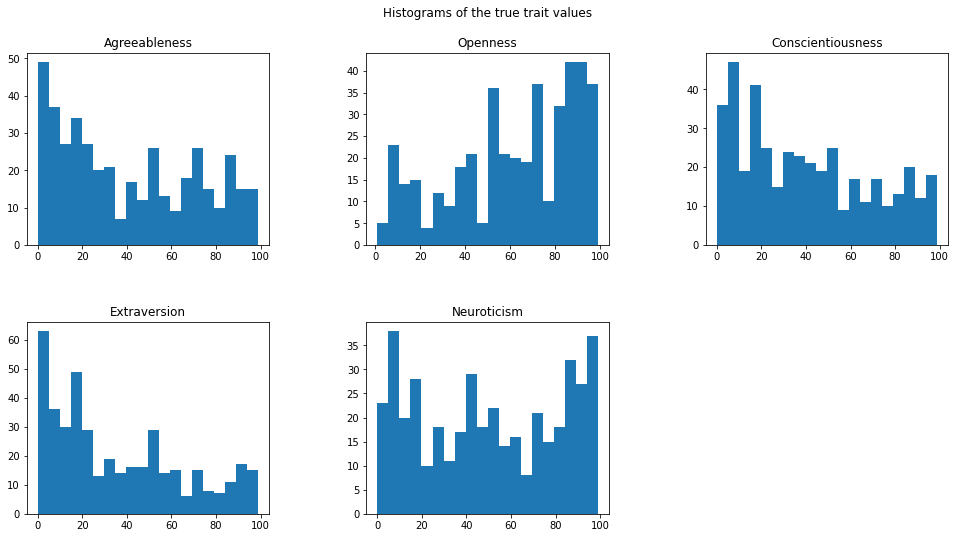

In [12]:
# true histogram plots
all_hist_true(df)

Trait to predict:  agree
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['webdev', 'rule no pornography', 'see character', 'sentence',
       'shady fantasy team', 'single', 'single good reason',
       'sit pull circuits', 'situation probably not', 'six one',
       'someone legally required', 'structure brain', 'structure brain much',
       'summed base', 'term rental', 'terrence', 'theatlantic com',
       'time tools not', 'trigger ideas', 'trump making utter', 'turns bit',
       'us browser client', 'use add', 'using donald example',
       'videos yet perhaps', 'voice actors', 'weapon would', 'weekend',
       'wingers want', 'work single wielding'],
      dtype='object') 



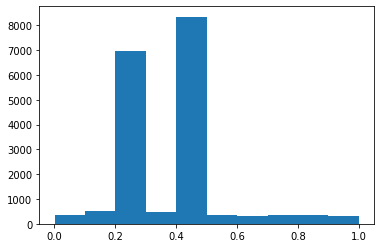


P-Values: 
                          Specs      Score   P-Value
16362                  terrence  11.352027  0.000848
14972        single good reason   9.245154  0.002560
16848            time tools not   8.642416  0.003528
14970                    single   8.314739  0.004204
17719        videos yet perhaps   8.025452  0.004911
231                      webdev   7.801548  0.005541
16421           theatlantic com   7.476267  0.006607
15006    situation probably not   7.258218  0.007437
17494                   use add   7.247628  0.007480
14753        shady fantasy team   6.992787  0.008595
14679                  sentence   6.916444  0.008961
15944               summed base   6.912924  0.008979
15839           structure brain   6.744336  0.009847
17466         us browser client   6.502782  0.011245
17224                 turns bit   6.357068  0.012186
15840      structure brain much   6.291654  0.012635
15241  someone legally required   6.159555  0.013593
17557      using donald example   

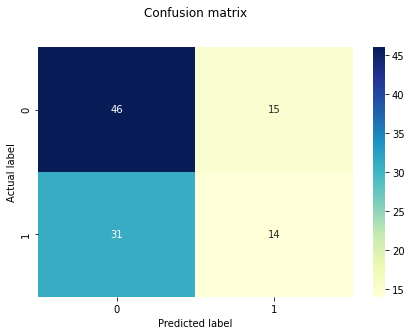

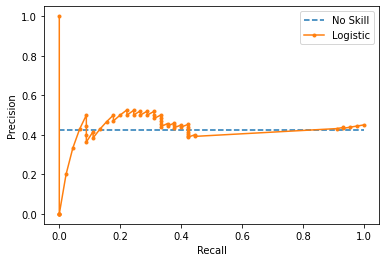

In [13]:
# Agreeableness
classify(df, "agree", start, plotting=True)

Trait to predict:  openn
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['num_subreddits', 'actually evaluating impression',
       'consenting adults tango', 'enough buy', 'every number first',
       'loves lana del', 'platinum might', 'russian two one', 'say probably',
       'seat famous', 'shady fantasy', 'shitpost', 'shows', 'sleeping dreams',
       'slipped fingers take', 'social interaction apart',
       'spine berserk thirteen', 'stating hard determinist',
       'suggestions development game', 'summarize brother', 'tine makes intps',
       'traits', 'trump usa', 'use probably', 'warriors', 'watch bulking also',
       'well every', 'work maybe see', 'work wages', 'work wages profits'],
      dtype='object') 



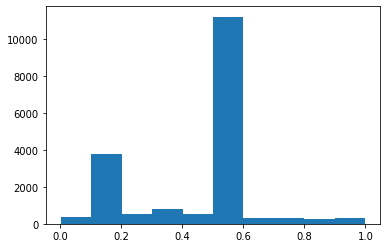


P-Values: 
                                Specs      Score   P-Value
17919              watch bulking also  10.118893  0.001614
14310                    say probably   9.788471  0.001921
18054                      well every   9.140457  0.002706
16885                tine makes intps   8.916164  0.003049
18350                      work wages   8.769774  0.003296
14460                     seat famous   8.683895  0.003451
17145                       trump usa   8.325374  0.004180
17914                        warriors   8.325374  0.004180
15936    suggestions development game   7.597307  0.006187
17051                          traits   7.585733  0.006226
15513          spine berserk thirteen   7.571814  0.006273
15093                 sleeping dreams   7.437366  0.006748
12648                  platinum might   7.377883  0.006969
14200                 russian two one   7.326801  0.007165
15106            slipped fingers take   7.326801  0.007165
3246          consenting adults tango   7.23

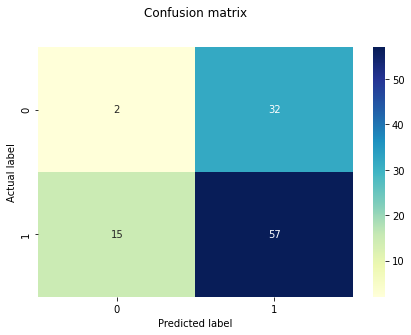

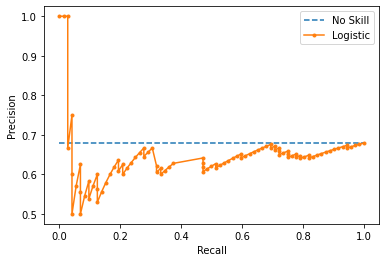

In [14]:
# Openness
classify(df, "openn", start, plotting=True)

Trait to predict:  consc
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['entps', 'going around one', 'scoringi', 'section added logan',
       'selective meet talk', 'self worth looks', 'sensing dominant example',
       'siblings somewhat', 'sick', 'skyrocket', 'smaller contract',
       'somewhere middle', 'spoken', 'subjective infj chicks',
       'subjective statement based', 'suffer noticed', 'support sniper',
       'synastry stronger', 'team lt three', 'theoretical le', 'think maybe',
       'think mean', 'thirteen', 'used super wide', 'username keep',
       'war really hoped', 'well still changing', 'well whole',
       'work probably', 'work type skating'],
      dtype='object') 



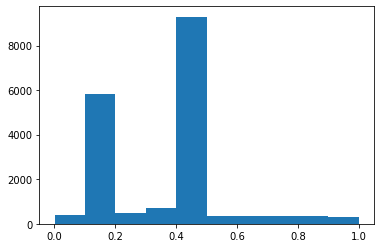


P-Values: 
                            Specs      Score   P-Value
18338               work probably  11.321208  0.000861
14611         selective meet talk  11.281225  0.000879
15890  subjective statement based  10.674242  0.001207
16248               team lt three  10.438445  0.001365
15888      subjective infj chicks   9.911236  0.001801
14406                    scoringi   9.627495  0.002091
6553             going around one   9.086717  0.002785
15926              suffer noticed   7.991783  0.005001
14664    sensing dominant example   7.873507  0.005330
14880                        sick   7.421928  0.006804
18347           work type skating   7.409957  0.006849
15120            smaller contract   7.365430  0.007016
17902            war really hoped   7.306472  0.007245
15517                      spoken   7.106947  0.008076
16100           synastry stronger   6.914843  0.008969
16624                    thirteen   6.829177  0.009400
14493         section added logan   6.826786  0.00941

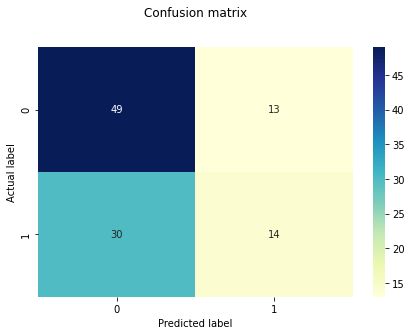

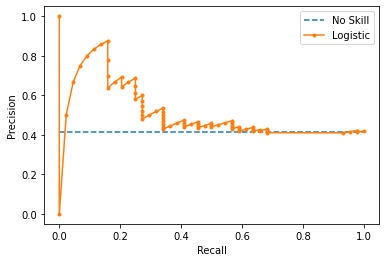

In [15]:
# Conscientiousness
classify(df, "consc", start, plotting=True)

Trait to predict:  extra
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['friday', 'sunday', 'magictcg', 'era sooo', 'like car', 'ray allen',
       'religion may correlated', 'rules mathematics', 'say probably not',
       'select', 'sent selfie four', 'sentence', 'shingles soooooo',
       'shingles thirty', 'smooth', 'somewhat',
       'somewhat dependent personality', 'standard light novel',
       'standards pretty much', 'switching watching', 'thing think hyper',
       'things others', 'tools not', 'turmoil', 'understanding good',
       'us browser client', 'well every', 'well see', 'well still',
       'work makes think'],
      dtype='object') 



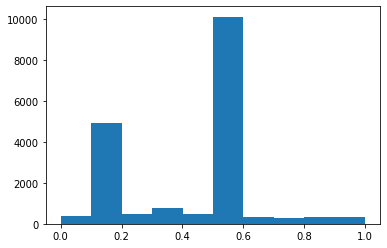


P-Values: 
                                Specs      Score   P-Value
14778                 shingles thirty  11.961496  0.000618
14679                        sentence  11.157475  0.000938
14678                sent selfie four  10.065174  0.001660
16082              switching watching   9.661731  0.002054
15142                          smooth   9.465232  0.002278
18068                        well see   8.958562  0.002981
14606                          select   8.885307  0.003099
16462               thing think hyper   8.358846  0.004106
13412                       ray allen   8.302207  0.004232
15326  somewhat dependent personality   8.239379  0.004377
17466               us browser client   8.187921  0.004500
14776                shingles soooooo   8.178480  0.004523
15324                        somewhat   7.794468  0.005562
15605           standards pretty much   7.756546  0.005677
8                              friday   7.754614  0.005683
18073                      well still   7.62

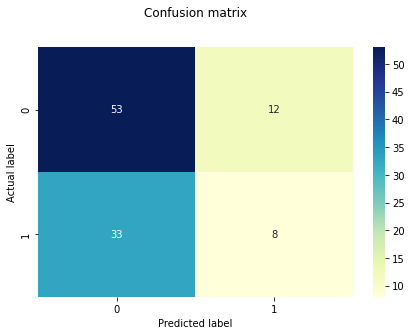

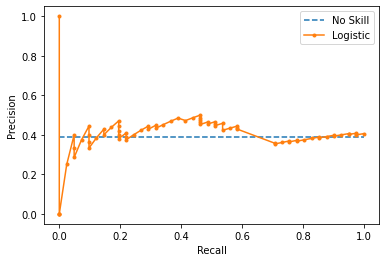

In [16]:
# Extraversion 
classify(df, "extra", start, plotting=True)

Trait to predict:  neuro
Number of authors in y_train:  316
Number of authors in y_test:  106


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  106
Names of the top 30 features: 
 Index(['depression', 'liberalgunowners', 'ray allen', 'said eager', 'saw look',
       'say dungeons kick', 'screen option one', 'seem presence cogfunc',
       'seems', 'sense empire', 'single minded', 'spi documentation',
       'spoiling', 'stereotypes', 'sweden happen', 'team standard scoringi',
       'telling straight', 'term governments not', 'tertiary', 'think two fan',
       'three rs jack', 'time would say', 'today another', 'tools ever go',
       'typo no need', 'verbally spatially', 'video recomp', 'warrior',
       'whenever', 'wheres'],
      dtype='object') 



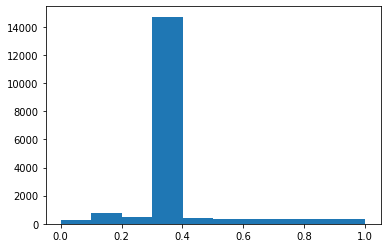


P-Values: 
                        Specs      Score   P-Value
18114                whenever  11.142521  0.000945
253          liberalgunowners  10.727248  0.001174
16368                tertiary  10.169537  0.001572
16594           think two fan   9.191681  0.002634
14418       screen option one   8.565239  0.003676
16861          time would say   7.853594  0.005387
14973           single minded   7.742924  0.005719
16256  team standard scoringi   7.650172  0.006013
15514                spoiling   7.201124  0.007672
14299       say dungeons kick   6.899462  0.009045
17322            typo no need   6.835124  0.009369
13412               ray allen   6.763667  0.009743
84                 depression   6.707610  0.010048
14293                saw look   6.689906  0.010146
16345    term governments not   6.688034  0.010156
17679      verbally spatially   6.592225  0.010705
16072           sweden happen   6.586139  0.010741
14654            sense empire   6.537430  0.011033
17715            vi

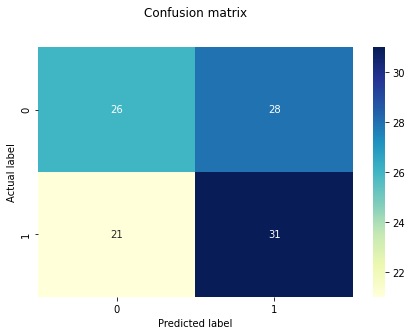

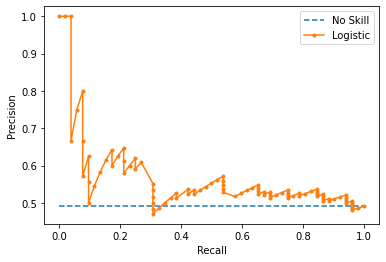

In [17]:
# Neuroticism
classify(df, "neuro", start, plotting=True)

# Results of the test set

In [18]:
def classify_trainset(df, trait_name, startnumber, plotting=True):
    print("Trait to predict: ", trait_name)
    x,y = trait(df, trait_name, startnumber)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    logpipe = create_pipeline(x_train, y_train, 'log')
    y_pred=logpipe.predict(x_train)
    print("Number of authors in y_pred: ", len(y_pred))
    names = get_names(x, logpipe)
    print("Names of the top", len(names), "features: \n", names, "\n")
    pvalues = get_pvalues(logpipe, x)
#     print("p-values of", len(pvalues), "features: \n", pvalues, "\n")
    print("\nP-Values: ")
    print(pvalues.nsmallest(30,'P-Value'))
    print("\n")
    cnfmatrix = create_cnfmatrix(y_train, y_pred, plotting=True) 
#     accuracy, precision, recall, f_one = scores(y_test, y_pred, "scores")
#     print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
    report = scores(y_train, y_pred, "report")
    print("Classification report: \n", report)
    lr_precision, lr_recall = score_plot(logpipe, y_train, x_train)
#     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)
    plt.show()
    print("\n \n")

# startnumber ngrams : 36
# startnumber wordlists: 29
# startnumber: linguistic features: 30
# startnumber: authorversion with arrays in user features: 26
start = 26
print ("Number of authors: ", len(authorset))

Number of authors:  422


Trait to predict:  agree


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  316
Names of the top 30 features: 
 Index(['italy', 'rule thumb would', 'see confirmation bias',
       'sentence phrase tl', 'shady see nice', 'single good reason',
       'single minded focus', 'sit wait told', 'situation us except',
       'six three', 'someone made similar', 'struggle', 'struggle follow',
       'sunday_ngram', 'term wussbier', 'terrence loves lana', 'thebiggipper',
       'time two', 'triggers', 'trump usa', 'twelve', 'us except even',
       'use burst', 'using eos potency', 'view group', 'voice rhythm', 'wear',
       'weekend bad timing', 'winner noah', 'work type skating'],
      dtype='object') 



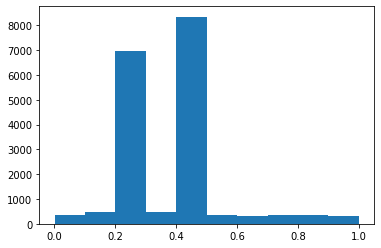


P-Values: 
                       Specs      Score   P-Value
16356    terrence loves lana  11.352027  0.000848
14966    single minded focus   9.245154  0.002560
16842               time two   8.642416  0.003528
14964     single good reason   8.314739  0.004204
17713             view group   8.025452  0.004911
225                    italy   7.801548  0.005541
16415           thebiggipper   7.476267  0.006607
15000    situation us except   7.258218  0.007437
17488              use burst   7.247628  0.007480
14747         shady see nice   6.992787  0.008595
14673     sentence phrase tl   6.916444  0.008961
15938           sunday_ngram   6.912924  0.008979
15833               struggle   6.744336  0.009847
17460         us except even   6.502782  0.011245
17218                 twelve   6.357068  0.012186
15834        struggle follow   6.291654  0.012635
15235   someone made similar   6.159555  0.013593
17551      using eos potency   6.076240  0.014236
15008              six three   6.03024

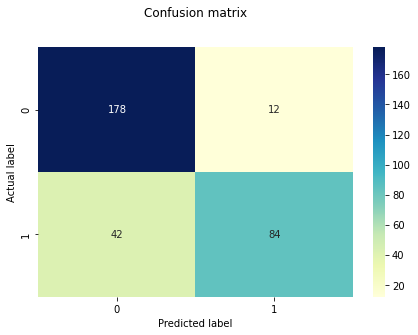

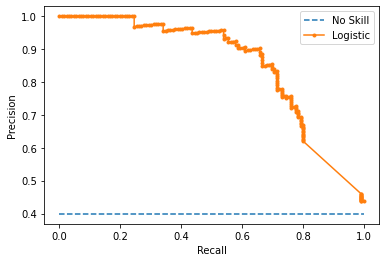


 

Trait to predict:  openn


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  316
Names of the top 30 features: 
 Index(['actually love talking', 'conservatism generally', 'enough develop',
       'every opposite one', 'loves soccer star', 'play', 'russians never',
       'say republican', 'seat worst', 'second', 'shady see', 'shitty',
       'shows cells contain', 'slid', 'slippery morning', 'social issue',
       'spoiling perception', 'station industry', 'suggestive images',
       'summed', 'tire even', 'traits correlated either', 'trust',
       'use probably vegetative', 'warriors definitely said',
       'watch pores not', 'well found', 'work not pay', 'work would',
       'work would guess'],
      dtype='object') 



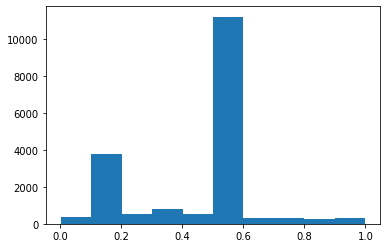


P-Values: 
                          Specs      Score   P-Value
17913           watch pores not  10.118893  0.001614
14304            say republican   9.788471  0.001921
18048                well found   9.140457  0.002706
16879                 tire even   8.916164  0.003049
18344                work would   8.769774  0.003296
14454                seat worst   8.683895  0.003451
17139                     trust   8.325374  0.004180
17908  warriors definitely said   8.325374  0.004180
15930         suggestive images   7.597307  0.006187
17045  traits correlated either   7.585733  0.006226
15507       spoiling perception   7.571814  0.006273
15087                      slid   7.437366  0.006748
12642                      play   7.377883  0.006969
14194            russians never   7.326801  0.007165
15100          slippery morning   7.326801  0.007165
3240     conservatism generally   7.234497  0.007534
5035         every opposite one   7.222966  0.007581
15167              social issue   

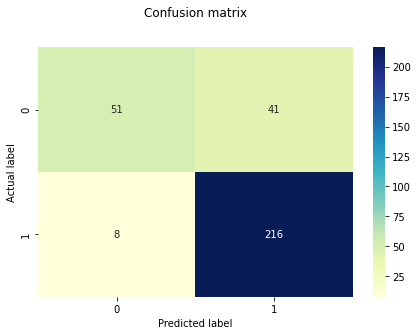

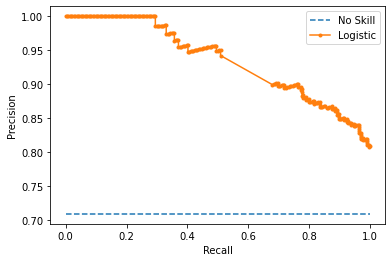


 

Trait to predict:  consc


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  316
Names of the top 30 features: 
 Index(['entps manipulation not', 'going big part', 'scoringi need one',
       'sections real', 'selene single', 'selfie four', 'sensors extroverts',
       'sick', 'sick name seeking', 'skyrocket end goal', 'smart', 'song',
       'spoken ddlg relationships', 'subjective statement based',
       'submission amp', 'suffering', 'supporter', 'sync',
       'team matches likely', 'theoretical level', 'think mean',
       'think misidentified', 'thirteen not cover', 'used work voice', 'users',
       'warm giving', 'well want everyone', 'well yeah', 'work rather',
       'work voice actors'],
      dtype='object') 



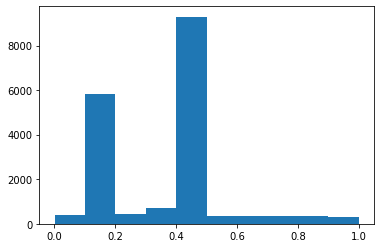


P-Values: 
                            Specs      Score   P-Value
18332                 work rather  11.321208  0.000861
14605               selene single  11.281225  0.000879
15884              submission amp  10.674242  0.001207
16242         team matches likely  10.438445  0.001365
15882  subjective statement based   9.911236  0.001801
14400           scoringi need one   9.627495  0.002091
6547               going big part   9.086717  0.002785
15920                   suffering   7.991783  0.005001
14658          sensors extroverts   7.873507  0.005330
14874           sick name seeking   7.421928  0.006804
18341           work voice actors   7.409957  0.006849
15114                       smart   7.365430  0.007016
17896                 warm giving   7.306472  0.007245
15511   spoken ddlg relationships   7.106947  0.008076
16094                        sync   6.914843  0.008969
16618          thirteen not cover   6.829177  0.009400
14487               sections real   6.826786  0.00941

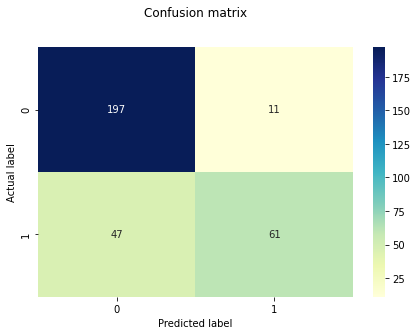

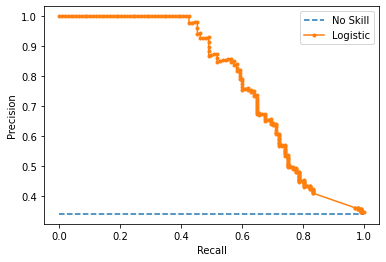


 

Trait to predict:  extra


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  316
Names of the top 30 features: 
 Index(['sunday', 'february', 'videos', 'ergonomics', 'like cogfunc',
       'ray fuck', 'religion not deep', 'run', 'say republican higher',
       'select card augment', 'sentence phrase', 'sentence phrase tl',
       'shingles thirty', 'shirt', 'smooth shown video',
       'somewhat dependent personality', 'somewhat invalidates not',
       'standard scoringi need', 'standing next', 'swollen', 'things like',
       'things place', 'tools worse', 'turn around', 'underwear',
       'us except even', 'well found', 'well shit', 'well want',
       'work maybe see'],
      dtype='object') 



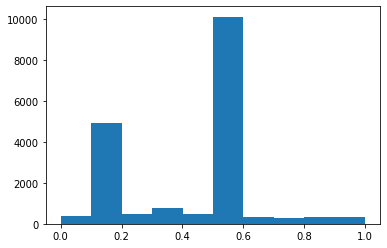


P-Values: 
                                Specs      Score   P-Value
14772                           shirt  11.961496  0.000618
14673              sentence phrase tl  11.157475  0.000938
14672                 sentence phrase  10.065174  0.001660
16076                         swollen   9.661731  0.002054
15136              smooth shown video   9.465232  0.002278
18062                       well shit   8.958562  0.002981
14600             select card augment   8.885307  0.003099
16456                     things like   8.358846  0.004106
13406                        ray fuck   8.302207  0.004232
15320        somewhat invalidates not   8.239379  0.004377
17460                  us except even   8.187921  0.004500
14770                 shingles thirty   8.178480  0.004523
15318  somewhat dependent personality   7.794468  0.005562
15599                   standing next   7.756546  0.005677
2                              sunday   7.754614  0.005683
18067                       well want   7.62

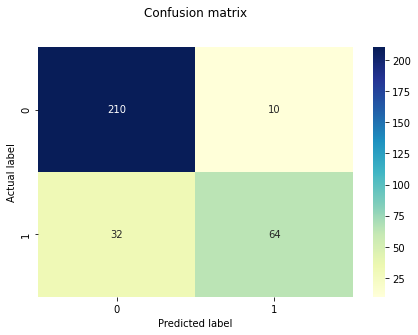

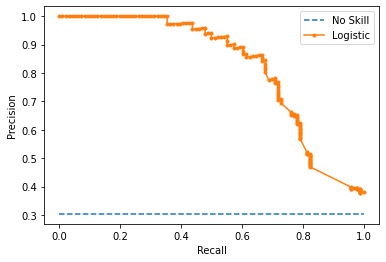


 

Trait to predict:  neuro


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Number of authors in y_pred:  316
Names of the top 30 features: 
 Index(['gatekeeping', '200yearsago', 'ray fuck', 'said multiple', 'say',
       'say even reliable', 'screens like', 'seemed case',
       'seems intuitively zero', 'sense get', 'single player', 'spi lcd',
       'spoiling perception western', 'stereotypes intuitives considered',
       'swimming pool', 'teams beat', 'tells', 'term potential idealistic',
       'tertiary auxiliary function', 'think visually verbally',
       'three second bring', 'timeless grow', 'today would', 'tools last long',
       'uk', 'versa', 'videos_ngram', 'warrior nerfed like',
       'whenever things released', 'wheres lasso need'],
      dtype='object') 



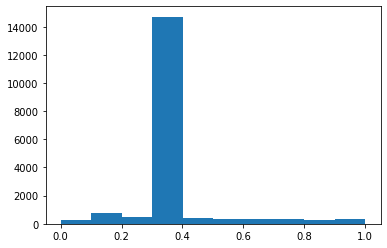


P-Values: 
                                   Specs      Score   P-Value
18108           whenever things released  11.142521  0.000945
247                          200yearsago  10.727248  0.001174
16362        tertiary auxiliary function  10.169537  0.001572
16588            think visually verbally   9.191681  0.002634
14412                       screens like   8.565239  0.003676
16855                      timeless grow   7.853594  0.005387
14967                      single player   7.742924  0.005719
16250                         teams beat   7.650172  0.006013
15508        spoiling perception western   7.201124  0.007672
14293                  say even reliable   6.899462  0.009045
17316                                 uk   6.835124  0.009369
13406                           ray fuck   6.763667  0.009743
78                           gatekeeping   6.707610  0.010048
14287                                say   6.689906  0.010146
16339          term potential idealistic   6.688034  0.010

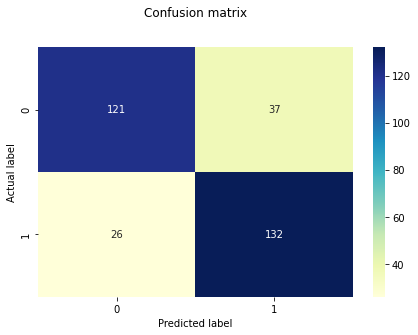

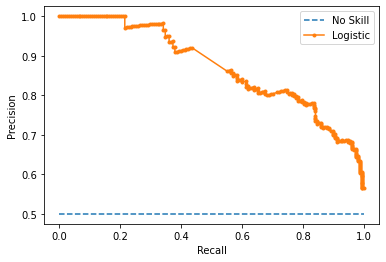

In [19]:
classify_trainset(df, "agree", start, plotting=True)
classify_trainset(df, "openn", start, plotting=True)
classify_trainset(df, "consc", start, plotting=True)
classify_trainset(df, "extra", start, plotting=True)
classify_trainset(df, "neuro", start, plotting=True)